# Importing Packages


In [1]:
# -----------------------------
# 1. Imports and Seed Setup
# -----------------------------

# Standard libraries
import os
import time
import json
import glob
import warnings
from pathlib import Path

# Scientific and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchinfo import summary

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Others
import joblib  # for saving the scaler
from tqdm import tqdm

# -----------------------------
# Reproducibility Setup
# -----------------------------
warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
cudnn.deterministic = True
cudnn.benchmark = False


# EDA

In [2]:
df = pd.read_csv('..\data\DrivAerNetPlusPlus_Drag_8k_cleaned.csv')
df.describe()

,Average Cd
count,7713.000000
mean,0.284412
std,0.037232
min,0.201138
25%,0.255859
50%,0.282987
75%,0.311521
max,0.383330


In [3]:
# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# Get current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")


CUDA Available: True
Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Allocated: 0.0 MB
Memory Cached: 0.0 MB


<Axes: xlabel='Average Cd', ylabel='Count'>

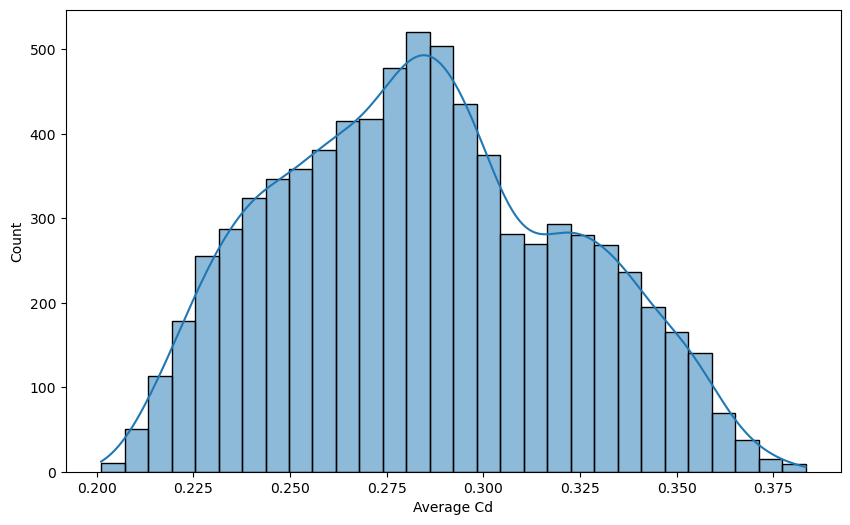

In [4]:
# Plot the pdf graph for Average Drag Coefficient (Cd)
plt.figure(figsize=(10, 6))
sns.histplot(df['Average Cd'], bins=30, kde=True)

# Pepraring Scaler Function and Global variables

In [5]:
# -----------------------------
# 1.2. Prepaing Scaler
# -----------------------------

# Subset to only training car IDs
with open("../data/subset_dir/train_design_ids.txt") as f:
    train_ids = [line.strip() for line in f]

df_train = df[df["Design"].isin(train_ids)]
scaler = StandardScaler()
scaler.fit(df_train[["Average Cd"]])

print(f"Scaler mean: {scaler.mean_[0]:.6f}, std: {scaler.scale_[0]:.6f}")

# Save scaler to disk
os.makedirs("../outputs", exist_ok=True)
joblib.dump(scaler, "../outputs/cd_scaler.pkl")

Scaler mean: 0.284506, std: 0.037448


['../outputs/cd_scaler.pkl']

In [6]:
# -----------------------------
# 1.3. Global Variables
# -----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

point_net_input_dim = 2
point_net_embedding_dim = 256
lstm_input_dim = point_net_embedding_dim
lstm_hidden_dim = 256
bidirectional = True
number_of_layers = 2
cd_regressor_input_dim = lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim
batch_size = 4

model_checkpoint_dir="../outputs/checkpoints3"
analysis_output_dir='../outputs/eval'

scaler = joblib.load("../outputs/cd_scaler.pkl")
assert hasattr(scaler, "mean_"), "Scaler not loaded correctly"


# Model

In [7]:
# -----------------------------
# LightPointNet2D: Efficient 2D PointNet
# -----------------------------
class PointNet2D(nn.Module):
    def __init__(self, input_dim=2, emb_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(input_dim, 32, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, emb_dim, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, mask=None):
        # x: (B*N, P, 2) → (B*N, 2, P)
        x = x.transpose(1, 2)  # (B, 2, N)
        features = self.mlp(x)  # (B, emb_dim, N)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, N)
            features = features.masked_fill(mask == 0, float('-inf'))

        # Global max pooling
        embedding = torch.max(features, dim=2)[0]  # (B, emb_dim)
        return embedding


In [8]:
# -----------------------------
# 3. LSTM Slice Encoder (Optimized)
# -----------------------------
class LSTMSliceEncoder(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512, num_layers=2, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2  # Dropout between layers
        )

    def forward(self, x):
        # Ensure input and model are on the same device
        assert x.device == next(self.parameters()).device, "Input and model are on different devices!"

        # x: (B, S, D)
        _, (h_n, _) = self.lstm(x)
        if self.lstm.bidirectional:
            return torch.cat((h_n[-2], h_n[-1]), dim=-1)  # (B, 2H)
        else:
            return h_n[-1]  # (B, H)


In [9]:
# -----------------------------
# 4. Cd Regressor MLP (Optimized)
# -----------------------------
class CdRegressor(nn.Module):
    def __init__(self, input_dim=1024):  # 512 * 2 from BiLSTM
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Ensure input and model are on the same device
        assert x.device == next(self.parameters()).device, "Input and model are on different devices!"
        return self.net(x).squeeze(1)


In [10]:
# -----------------------------
# 5. Full Model Assembly (Optimized)
# -----------------------------
class CdPredictorNet(nn.Module):
    def __init__(self, pointnet, lstm_encoder, regressor):
        super().__init__()
        self.pointnet = pointnet
        self.lstm_encoder = lstm_encoder
        self.regressor = regressor

    def forward(self, slices, point_mask, slice_mask):
        # slices: (B, S, N, D)
        B, S, N, D = slices.shape

        # Optional: Device consistency check
        assert slices.device == next(self.parameters()).device, "Input slices not on same device as model."

        # Flatten slices and masks
        flat_slices = slices.reshape(B * S, N, D)
        flat_mask = point_mask.reshape(B * S, N)

        # Encode each slice
        slice_embs = self.pointnet(flat_slices, flat_mask)  # (B*S, 256)
        slice_embs = slice_embs.view(B, S, -1)  # (B, S, 256)

        # Temporal encoding with LSTM
        car_emb = self.lstm_encoder(slice_embs)  # (B, 1024 if bidirectional)

        # Final regression
        return self.regressor(car_emb)


# Dataset loader and Model Summary

In [11]:
# -----------------------------
# 6. Dataset Loader (Optimized)
# -----------------------------
class CarSlicesDataset(torch.utils.data.Dataset):
    def __init__(self, ids_txt, npz_dir, csv_path, max_cars=None, scaler = None):
        """
        Args:
            ids_txt (str): Path to the text file containing car IDs.
            npz_dir (str): Directory containing the .npz files.
            csv_path (str): Path to the CSV file with Cd values.
            max_cars (int, optional): Limit the number of cars to load. Defaults to None.
            scaler (object, optional): Scaler object for normalizing Cd values. Defaults to None.
        """
        self.car_ids = [line.strip() for line in open(ids_txt)]
        if max_cars:
            self.car_ids = self.car_ids[:max_cars]
        self.npz_dir = npz_dir
        self.cd_map = pd.read_csv(csv_path).set_index("Design")["Average Cd"].to_dict()
        self.scaler = scaler if scaler else None

    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        
        car_id = self.car_ids[idx]
        data = np.load(os.path.join(self.npz_dir, f"{car_id}_axis-x.npz"))

        # Keep in NumPy for now (better for pin_memory and batch collation)
        slices = data["slices"].astype(np.float32)         # (80, 6500, 2)
        point_mask = data["point_mask"].astype(np.float32) # (80, 6500)
        slice_mask = data["slice_mask"].astype(np.float32) # (80,)
        cd_value = np.float32(self.cd_map[car_id])

        if self.scaler:
            cd_value = self.scaler.transform([[cd_value]])[0, 0]

        return slices, point_mask, slice_mask, cd_value


In [12]:
# Create model
pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
lstm_encoder = LSTMSliceEncoder(input_dim=lstm_input_dim, hidden_dim=lstm_hidden_dim, num_layers=number_of_layers, bidirectional=bidirectional)
regressor = CdRegressor(input_dim=cd_regressor_input_dim)
model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

# Print model summary (example input: batch_size=2, slices=80, points=6500, dim=2)
summary(model, input_data=(
    torch.zeros(batch_size, 80, 6500, 2).to(device),
    torch.ones(batch_size, 80, 6500).to(device),
    torch.ones(batch_size, 80).to(device)
))


Layer (type:depth-idx)                   Output Shape              Param #
CdPredictorNet                           [4]                       --
├─PointNet2D: 1-1                        [320, 256]                --
│    └─Sequential: 2-1                   [320, 256, 6500]          --
│    │    └─Conv1d: 3-1                  [320, 32, 6500]           96
│    │    └─ReLU: 3-2                    [320, 32, 6500]           --
│    │    └─Conv1d: 3-3                  [320, 64, 6500]           2,112
│    │    └─ReLU: 3-4                    [320, 64, 6500]           --
│    │    └─Conv1d: 3-5                  [320, 256, 6500]          16,640
│    │    └─ReLU: 3-6                    [320, 256, 6500]          --
├─LSTMSliceEncoder: 1-2                  [4, 512]                  --
│    └─LSTM: 2-2                         [4, 80, 512]              2,629,632
├─CdRegressor: 1-3                       [4]                       --
│    └─Sequential: 2-3                   [4, 1]                    --
│

# Training Loop

## Helper Function

In [13]:

def evaluate_model(model, val_loader, device, scaler):
    model.eval()
    preds, trues = [], []

    start = time.time()
    with torch.no_grad():
        for slices, point_mask, slice_mask, cd_gt in val_loader:
            slices = slices.to(device, non_blocking=True)
            point_mask = point_mask.to(device, non_blocking=True)
            slice_mask = slice_mask.to(device, non_blocking=True)
            cd_gt = cd_gt.to(device, non_blocking=True).float()

            pred = model(slices, point_mask, slice_mask)
            preds.append(pred)
            trues.append(cd_gt)

    preds = torch.cat(preds).cpu().numpy()
    trues = torch.cat(trues).cpu().numpy()

    if scaler:
        preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        trues = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # Metrics
    r2 = r2_score(trues, preds)
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    mape = np.mean(np.abs((trues - preds) / (trues + 1e-8))) * 100  # small constant for stability

    # Normalized Absolute Error (based on range)
    value_range = np.max(trues) - np.min(trues)
    nmae = np.mean(np.abs(trues - preds) / (value_range + 1e-8))

    print(f"\n📊 Validation Metrics:")
    print(f"🔹 R²   = {r2:.4f}")
    print(f"🔹 MSE  = {mse:.6f}")
    print(f"🔹 RMSE = {rmse:.6f}")
    print(f"🔹 MAE  = {mae:.6f}")
    print(f"🔹 MAPE = {mape:.2f}%")
    print(f"🔹 NMAE  = {nmae:.4f}")
    print(f"⏱️ Time taken: {time.time() - start:.2f} seconds")

    return {"r2": r2, "mse": mse, "rmse": rmse, "mae": mae, "mape": mape, "nmae": nmae}


## Main Training Loop

In [14]:
# -----------------------------
# 7. Training Loop (Updated)
# -----------------------------

def train_model(resume=True, num_epochs=50, max_cars=2000, validation_set_size=200,
                checkpoint_dir=model_checkpoint_dir, early_stopping_patience=5):
    import time

    # Initialize model using global config
    pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    lstm_encoder = LSTMSliceEncoder(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_hidden_dim,
        num_layers=number_of_layers,
        bidirectional=bidirectional
    )
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.SmoothL1Loss()

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    best_loss = float("inf")
    patience_counter = 0
    epoch_losses = []

    # Resume from checkpoint if available
    if resume:
        checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*_loss*.pt")))
        if checkpoints:
            latest_ckpt = checkpoints[-1]
            print(f"🔄 Resuming from checkpoint: {latest_ckpt}")
            state = torch.load(latest_ckpt, map_location=device)
            model.load_state_dict(state['model'])
            optimizer.load_state_dict(state['optimizer'])
            start_epoch = state['epoch'] + 1
            epoch_losses = state.get('epoch_losses', [])
            best_loss = min(epoch_losses) if epoch_losses else float("inf")
        else:
            print("⏩ No previous checkpoint found, starting fresh.")

    # Dataset & Dataloaders
    train_dataset = CarSlicesDataset(
        ids_txt="../data/subset_dir/train_design_ids.txt",
        npz_dir="../outputs/pad_masked_slices",
        csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
        max_cars=max_cars,
        scaler=scaler
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
    )

    val_dataset = CarSlicesDataset(
        ids_txt="../data/subset_dir/val_design_ids.txt",
        npz_dir="../outputs/pad_masked_slices",
        csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
        max_cars=validation_set_size,
        scaler=scaler
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
    )

    print(f"📦 Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples.")

    try:
        for epoch in range(start_epoch, num_epochs + 1):
            model.train()
            total_loss = 0.0
            start_time = time.time()
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", unit="batch")

            for slices, point_mask, slice_mask, cd_gt in pbar:

                slices = slices.to(device, non_blocking=True)
                point_mask = point_mask.to(device, non_blocking=True)
                slice_mask = slice_mask.to(device, non_blocking=True)
                cd_gt = cd_gt.to(device, non_blocking=True).float()

                pred = model(slices, point_mask, slice_mask)
                loss = loss_fn(pred, cd_gt)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = loss.item() * slices.size(0)
                total_loss += batch_loss
                pbar.set_postfix(loss=batch_loss / slices.size(0))

            avg_loss = total_loss / len(train_dataloader.dataset)
            epoch_losses.append(avg_loss)
            print(f"\n✅ Epoch {epoch}: Avg SmoothL1 Loss = {avg_loss:.7f}")

            # 🔍 Validation
            print(f"🔍 Evaluating on validation set:")
            evaluate_model(model, val_loader, device, scaler)

            print(f"⏱️ Epoch Time: {time.time() - start_time:.2f}s")

            # 💾 Save checkpoint
            ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch:02d}_loss_{avg_loss:.8f}.pt")
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch_losses': epoch_losses
            }, ckpt_path)
            print(f"💾 Checkpoint saved: {ckpt_path}")

            # 🏆 Save best model separately
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
                print("🏆 Best model updated.")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"🛑 Early stopping at epoch {epoch}.")
                    break

            print("-" * 60)

    except KeyboardInterrupt:
        print("\n⛔ Interrupted. Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch_losses': epoch_losses
        }, os.path.join(checkpoint_dir, f"interrupted_epoch_{epoch}.pt"))
        print("🧷 Last checkpoint saved.")

    return model, epoch_losses

# Training Model

In [15]:
# model, loss_log = train_model(
#     resume=True,                        # Set to True if you want to continue from a saved checkpoint
#     num_epochs=100,
#     max_cars=None,                       # Use entire dataset
#     checkpoint_dir=model_checkpoint_dir,
#     early_stopping_patience=5
# )

# Evaluation


📄 Saved compiled loss log to: ../outputs/eval\compiled_epoch_losses.json


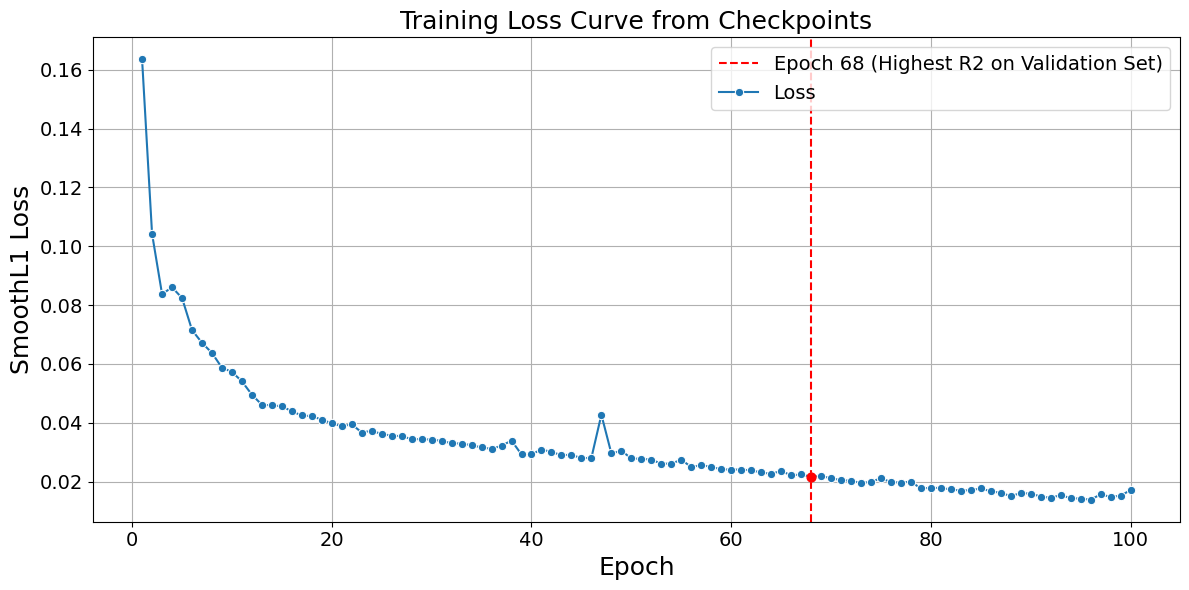

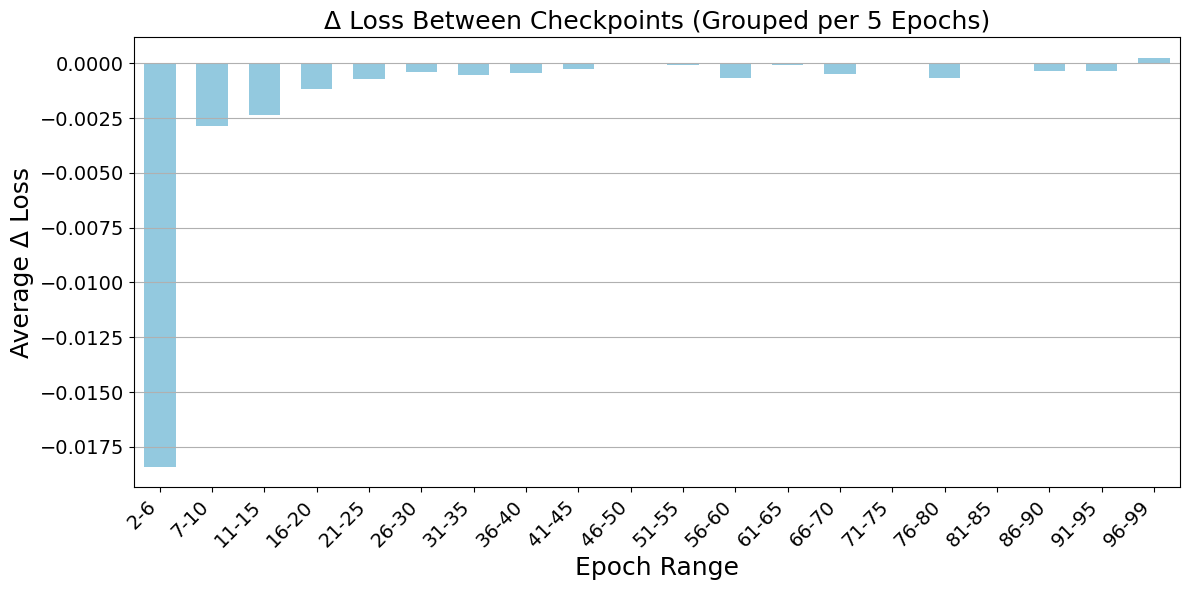

✅ Done analyzing 100 checkpoints


In [16]:
def analyze_all_checkpoints(checkpoint_dir="../outputs/temp_checkpoints", output_dir="../outputs/temp_analysis", highlight_epoch=68):
    os.makedirs(output_dir, exist_ok=True)
    
    checkpoint_paths = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt")))
    all_epoch_losses = []
    epoch_numbers = []

    for ckpt_path in checkpoint_paths:
        try:
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            losses = checkpoint.get("epoch_losses", [])
            epoch = checkpoint.get("epoch", None)

            if epoch is not None and losses:
                epoch_numbers.append(epoch)
                last_loss = losses[-1]
                all_epoch_losses.append(last_loss)

        except Exception as e:
            print(f"⚠️ Skipped {ckpt_path}: {e}")

    if not epoch_numbers:
        print("❌ No valid checkpoints found.")
        return

    # Save compiled loss log
    loss_log_path = os.path.join(output_dir, "compiled_epoch_losses.json")
    with open(loss_log_path, "w") as f:
        json.dump({
            "epoch_numbers": epoch_numbers,
            "epoch_losses": all_epoch_losses
        }, f, indent=2)
    print(f"\n📄 Saved compiled loss log to: {loss_log_path}")

    #################
    # Plot loss curve
    #################

    plt.figure(figsize=(12, 6))
    plt.axvline(x=highlight_epoch, color='red', linestyle='--', label=f"Epoch {highlight_epoch} (Highest R2 on Validation Set)")
    plt.scatter(highlight_epoch, all_epoch_losses[epoch_numbers.index(highlight_epoch)], color='red', s=40, zorder=5)
    sns.lineplot(x=epoch_numbers, y=all_epoch_losses, marker="o", markersize=6, linewidth=1.5, label="Loss")
    plt.title("Training Loss Curve from Checkpoints", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("SmoothL1 Loss", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_curve_from_ckpts.png"), dpi=300)
    plt.show()
    plt.close()

    # Plot deltas
    if len(all_epoch_losses) > 1:
        loss_deltas = [all_epoch_losses[i] - all_epoch_losses[i-1] for i in range(1, len(all_epoch_losses))]
        delta_epochs = epoch_numbers[1:]

        group_size = 5
        grouped_epochs = [f"{delta_epochs[i]}-{delta_epochs[min(i + group_size - 1, len(delta_epochs)-1)]}" 
                        for i in range(0, len(delta_epochs), group_size)]
        grouped_deltas = [
            np.mean(loss_deltas[i:i+group_size]) 
            for i in range(0, len(loss_deltas), group_size)
        ]

        plt.figure(figsize=(12, 6))
        sns.barplot(x=grouped_epochs, y=grouped_deltas, color='skyblue', width=0.6)
        plt.title("Δ Loss Between Checkpoints (Grouped per 5 Epochs)", fontsize=18)
        plt.xlabel("Epoch Range", fontsize=18)
        plt.ylabel("Average Δ Loss", fontsize=18)
        plt.xticks(rotation=45, ha='right', fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "loss_deltas_grouped_by_5_epochs.png"), dpi=300)
        plt.show()
        plt.close()

    print(f"✅ Done analyzing {len(epoch_numbers)} checkpoints")


analyze_all_checkpoints(checkpoint_dir=model_checkpoint_dir, output_dir=analysis_output_dir) 


Found 100 checkpoints.
⚠️ Epoch 1 already evaluated.
⚠️ Epoch 2 already evaluated.
⚠️ Epoch 3 already evaluated.
⚠️ Epoch 4 already evaluated.
⚠️ Epoch 5 already evaluated.
⚠️ Epoch 6 already evaluated.
⚠️ Epoch 7 already evaluated.
⚠️ Epoch 8 already evaluated.
⚠️ Epoch 9 already evaluated.
⚠️ Epoch 100 already evaluated.
⚠️ Epoch 10 already evaluated.
⚠️ Epoch 11 already evaluated.
⚠️ Epoch 12 already evaluated.
⚠️ Epoch 13 already evaluated.
⚠️ Epoch 14 already evaluated.
⚠️ Epoch 15 already evaluated.
⚠️ Epoch 16 already evaluated.
⚠️ Epoch 17 already evaluated.
⚠️ Epoch 18 already evaluated.
⚠️ Epoch 19 already evaluated.
⚠️ Epoch 20 already evaluated.
⚠️ Epoch 21 already evaluated.
⚠️ Epoch 22 already evaluated.
⚠️ Epoch 23 already evaluated.
⚠️ Epoch 24 already evaluated.
⚠️ Epoch 25 already evaluated.
⚠️ Epoch 26 already evaluated.
⚠️ Epoch 27 already evaluated.
⚠️ Epoch 28 already evaluated.
⚠️ Epoch 29 already evaluated.
⚠️ Epoch 30 already evaluated.
⚠️ Epoch 31 already eval

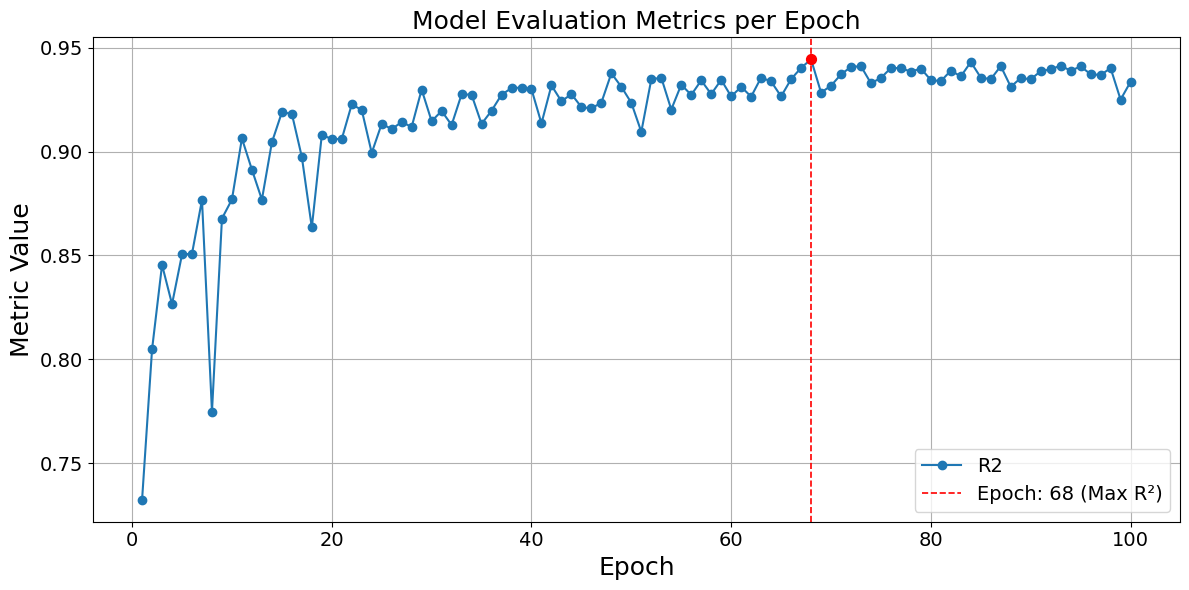

In [17]:
# Modify these paths according to your project
checkpoint_dir = Path("../outputs/checkpoints3")
eval_log_path = Path("../outputs/eval/epoch_metrics_log.json")
npz_dir = Path("../outputs/pad_masked_slices")
csv_path = Path("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
test_ids_file = Path("../data/subset_dir/val_design_ids.txt")

# Load test design IDs
with open(test_ids_file) as f:
    test_ids = [line.strip() for line in f]

# Load true Cd values
df = pd.read_csv(csv_path)
cd_map = dict(zip(df["Design"], df["Average Cd"]))

# Load existing metrics log
if eval_log_path.exists():
    with open(eval_log_path) as f:
        metrics_log = json.load(f)
else:
    metrics_log = {}

# List all checkpoint files
ckpt_paths = sorted(checkpoint_dir.glob("epoch_*.pt"))
print(f"Found {len(ckpt_paths)} checkpoints.")

# Replace this with your actual model loader
def load_model(path):
    pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    lstm_encoder = LSTMSliceEncoder(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_hidden_dim,
        num_layers=number_of_layers,
        bidirectional=bidirectional
    )
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    model.load_state_dict(torch.load(path, map_location=device)["model"])
    model.eval()
    return model

# Evaluate missing epochs
for ckpt_path in ckpt_paths:
    epoch = int(ckpt_path.stem.split("_")[1])
    if str(epoch) in metrics_log:
        print(f"⚠️ Epoch {epoch} already evaluated.")
        continue  # already processed

    model = load_model(ckpt_path)
    preds, trues = [], []

    for car_id in test_ids:
        path = npz_dir / f"{car_id}_axis-x.npz"
        if not path.exists():
            continue
        data = np.load(path)
        slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
        point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
        slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

        with torch.no_grad():
            pred_scaled = model(slices, point_mask, slice_mask).item()
            pred_cd = scaler.inverse_transform([[pred_scaled]])[0][0]
        true_cd = cd_map[car_id]

        preds.append(pred_cd)
        trues.append(true_cd)

    r2 = r2_score(trues, preds)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mse)

    metrics_log[str(epoch)] = {
        "r2": r2,
        "mse": mse,
        "rmse": rmse,
        "mae": mae
    }

    with open(eval_log_path, "w") as f:
        json.dump(metrics_log, f, indent=2)
    print(f"✅ Epoch {epoch} evaluated.")

# Plotting
metrics_df = pd.DataFrame([
    {"epoch": int(k), **v} for k, v in metrics_log.items()
]).sort_values("epoch")

plt.figure(figsize=(12, 6))
for metric in ["r2"]:
    plt.plot(
        metrics_df["epoch"], 
        metrics_df[metric], 
        marker="o", 
        label=metric.upper(), 
        markersize=6, 
        linewidth=1.5
    )
best_epoch = metrics_df.loc[metrics_df["r2"].idxmax(), "epoch"]
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f"Epoch: {int(best_epoch)} (Max R²)", linewidth=1.2)
plt.scatter(
    best_epoch, 
    metrics_df.loc[metrics_df["epoch"] == best_epoch, "r2"], 
    color='red', 
    s=50, 
    zorder=5
)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Metric Value", fontsize=18)
plt.title("Model Evaluation Metrics per Epoch", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/eval/metric_trends.png", dpi=300)
plt.show()

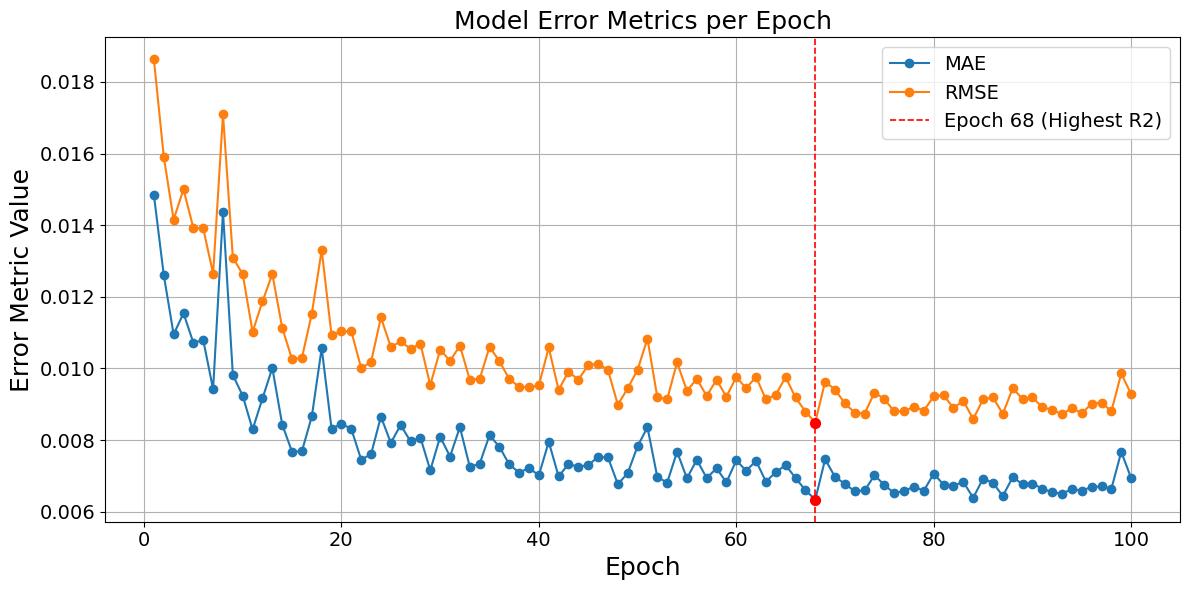

In [18]:
# Assuming metrics_df is created as in the provided code
metrics_df = pd.DataFrame([
    {"epoch": int(k), **v} for k, v in metrics_log.items()
]).sort_values("epoch")

plt.figure(figsize=(12, 6))
for metric in ["mae", "rmse"]:
    plt.plot(
        metrics_df["epoch"], 
        metrics_df[metric], 
        marker="o", 
        label=metric.upper(), 
        markersize=6, 
        linewidth=1.5
    )

highlight_epoch = metrics_df.loc[metrics_df["r2"].idxmax(), "epoch"]

plt.axvline(
    x=highlight_epoch, 
    color='red', 
    linestyle='--', 
    linewidth=1.2, 
    label=f"Epoch {highlight_epoch} (Highest R2)"
)
plt.scatter(
    highlight_epoch, 
    metrics_df.loc[metrics_df["epoch"] == highlight_epoch, "mae"], 
    color='red', 
    s=50, 
    zorder=5
)
plt.scatter(
    highlight_epoch, 
    metrics_df.loc[metrics_df["epoch"] == highlight_epoch, "rmse"], 
    color='red', 
    s=50, 
    zorder=5
)

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Error Metric Value", fontsize=18)
plt.title("Model Error Metrics per Epoch", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/eval/error_metric_trends.png", dpi=300)
plt.show()


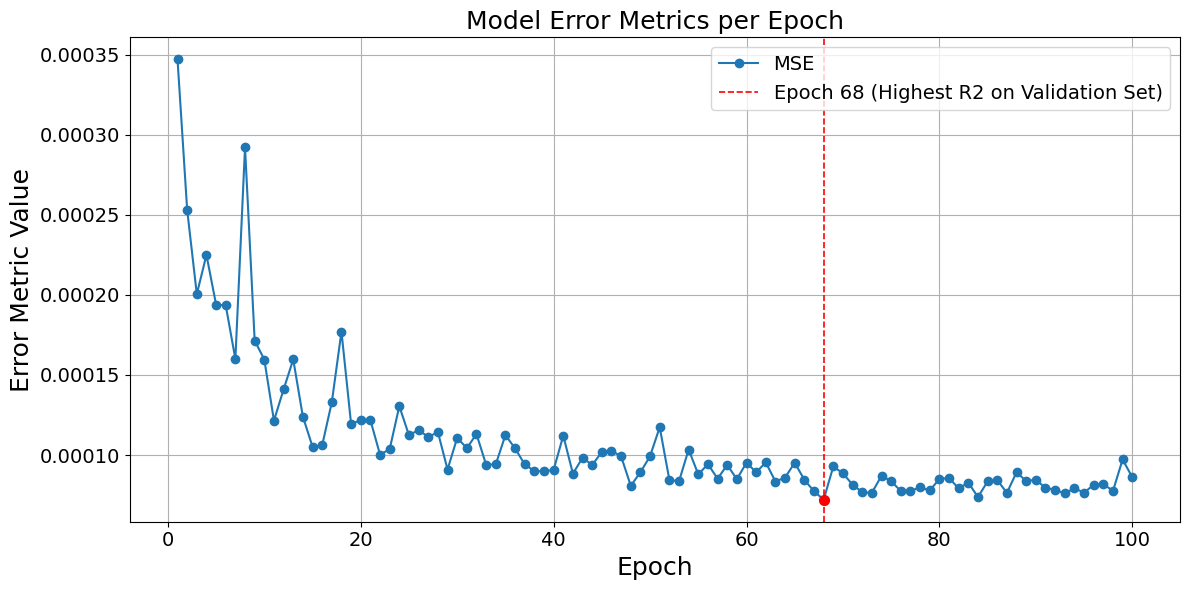

In [19]:
# Assuming metrics_df is created as in the provided code
metrics_df = pd.DataFrame([
    {"epoch": int(k), **v} for k, v in metrics_log.items()
]).sort_values("epoch")

plt.figure(figsize=(12, 6))
for metric in ["mse"]:
    plt.plot(
        metrics_df["epoch"], 
        metrics_df[metric], 
        marker="o", 
        label=metric.upper(), 
        markersize=6, 
        linewidth=1.5
    )

highlight_epoch = metrics_df.loc[metrics_df["r2"].idxmax(), "epoch"]
plt.axvline(
    x=highlight_epoch, 
    color='red', 
    linestyle='--', 
    linewidth=1.2, 
    label=f"Epoch {highlight_epoch} (Highest R2 on Validation Set)"
)
plt.scatter(
    highlight_epoch, 
    metrics_df.loc[metrics_df["epoch"] == highlight_epoch, "mse"], 
    color='red', 
    s=50, 
    zorder=5
)

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Error Metric Value", fontsize=18)
plt.title("Model Error Metrics per Epoch", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/eval/error_metric_trends.png", dpi=300)
plt.show()


In [20]:
def load_best_model(model_checkpoint_dir = model_checkpoint_dir):
    """
    Loads the best model saved in `best_model.pt` using global architecture settings.
    """
    best_model_path = os.path.join(model_checkpoint_dir, "epoch_68_loss_0.02162494.pt")

    # Recreate model architecture using global config
    pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    lstm_encoder = LSTMSliceEncoder(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_hidden_dim,
        num_layers=number_of_layers,
        bidirectional=bidirectional
    )
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    best_model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    if os.path.exists(best_model_path):
        best_model.load_state_dict(torch.load(best_model_path, map_location=device)['model'])
        best_model.eval()
        print(f"🏆 Loaded best model from: {best_model_path}")
    else:
        print(f"❌ No best_model.pt found at: {best_model_path}")

    return best_model

temp_model = load_best_model(model_checkpoint_dir)  # New clean instance, separate from training-time model

🏆 Loaded best model from: ../outputs/checkpoints3\epoch_68_loss_0.02162494.pt


In [21]:
# Assumes temp_model and scaler are already loaded
assert temp_model is not None, "temp_model is not loaded."
assert hasattr(scaler, "scale_") and hasattr(scaler, "mean_"), "Scaler must have 'scale_' and 'mean_' attributes"

temp_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()
if use_amp:
    from torch.cuda.amp import autocast

# Input splits
id_files = [
    "../data/subset_dir/test_design_ids.txt",
    "../data/subset_dir/val_design_ids.txt",
    "../data/subset_dir/train_design_ids.txt"
]

# Ground-truth Cd values
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
cd_map = dict(zip(df["Design"], df["Average Cd"]))

eval_dir = "../outputs/eval"
os.makedirs(eval_dir, exist_ok=True)

for id_file in id_files:
    split_name = os.path.basename(id_file).replace(".txt", "")
    filename = f"cd_predictions_{split_name}.csv"
    out_path = os.path.join(eval_dir, filename)
    summary_path = os.path.join(eval_dir, f"cd_predictions_{split_name}_summary.txt")

    if os.path.exists(out_path) and os.path.exists(summary_path):
        print(f"\n⚠️  Found existing prediction and summary for {split_name}.")
        print(f"📄 Loading predictions from: {out_path}")
        print(f"📄 Loading summary from: {summary_path}")

        # Load predictions
        df_pred = pd.read_csv(out_path)
        preds_np = df_pred["Predicted Cd"].values
        trues_np = df_pred["True Cd"].values
        ids_used = df_pred["Design ID"].tolist()
        times_np = np.array([0] * len(preds_np))  # Placeholder

        # Load and print summary
        with open(summary_path, "r") as f:
            summary = f.read()
        print(summary)
        continue

    print(f"\n🔍 Evaluating on {split_name}:")
    with open(id_file) as f:
        test_ids = [line.strip() for line in f]

    preds, trues, ids_used, times = [], [], [], []

    for car_id in tqdm(test_ids, desc="🔄 Evaluating cars", ncols=80):
        npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
        if not os.path.exists(npz_path):
            print(f"⚠️ Missing file: {car_id}")
            continue

        data = np.load(npz_path)
        slices = torch.from_numpy(data["slices"]).float().to(device).unsqueeze(0)
        point_mask = torch.from_numpy(data["point_mask"]).float().to(device).unsqueeze(0)
        slice_mask = torch.from_numpy(data["slice_mask"]).float().to(device).unsqueeze(0)

        start_time = time.perf_counter()
        with torch.no_grad():
            if use_amp:
                with autocast():
                    cd_scaled = temp_model(slices, point_mask, slice_mask).item()
            else:
                cd_scaled = temp_model(slices, point_mask, slice_mask).item()
        end_time = time.perf_counter()

        cd_pred = (cd_scaled * scaler.scale_[0]) + scaler.mean_[0]
        cd_true = cd_map.get(car_id)
        if cd_true is None:
            print(f"⚠️ No ground truth for {car_id}")
            continue

        preds.append(cd_pred)
        trues.append(cd_true)
        ids_used.append(car_id)
        times.append(end_time - start_time)

    preds_np = np.array(preds)
    trues_np = np.array(trues)
    times_np = np.array(times)

    # Save predictions
    pd.DataFrame({
        "Design ID": ids_used,
        "Predicted Cd": preds,
        "True Cd": trues
    }).to_csv(out_path, index=False)
    print(f"💾 Saved predictions to: {out_path}")

    # Metrics
    r2 = r2_score(trues_np, preds_np)
    mse = mean_squared_error(trues_np, preds_np)
    rmse = np.sqrt(mse)
    mean_ae = mean_absolute_error(trues_np, preds_np)
    max_ae = np.max(np.abs(trues_np - preds_np))
    mape = np.mean(np.abs((trues_np - preds_np) / trues_np)) * 100
    avg_infer_time = np.mean(times_np)

    summary = (
        f"\n📊 Evaluation Summary ({split_name}):\n"
        f"🔹 R² Score                 : {r2:.4f}\n"
        f"🔹 MSE                      : {mse:.6f}\n"
        f"🔹 RMSE                     : {rmse:.6f}\n"
        f"🔹 Mean_Absolute_Error(MAE) : {mean_ae:.6f}\n"
        f"🔹 Max_Absolute_Error(MAE)  : {max_ae:.4f}\n"
        f"🔹 MAPE                     : {mape:.2f}%\n"
        f"🔹 Cars tested              : {len(preds_np)}\n"
        f"🔹 Avg inference time       : {avg_infer_time:.6f} sec\n"
        f"{'-' * 60}\n"
    )

    print(summary)

    with open(summary_path, "w") as f:
        f.write(summary)
    print(f"📝 Saved evaluation summary to: {summary_path}")



⚠️  Found existing prediction and summary for test_design_ids.
📄 Loading predictions from: ../outputs/eval\cd_predictions_test_design_ids.csv
📄 Loading summary from: ../outputs/eval\cd_predictions_test_design_ids_summary.txt

📊 Evaluation Summary (test_design_ids):
🔹 R² Score                 : 0.9525
🔹 MSE                      : 0.000066
🔹 RMSE                     : 0.008148
🔹 Mean_Absolute_Error(MAE) : 0.006111
🔹 Max_Absolute_Error(MAE)  : 0.0450
🔹 MAPE                     : 2.23%
🔹 Cars tested              : 1158
🔹 Avg inference time       : 0.024953 sec
------------------------------------------------------------


⚠️  Found existing prediction and summary for val_design_ids.
📄 Loading predictions from: ../outputs/eval\cd_predictions_val_design_ids.csv
📄 Loading summary from: ../outputs/eval\cd_predictions_val_design_ids_summary.txt

📊 Evaluation Summary (val_design_ids):
🔹 R² Score                 : 0.9443
🔹 MSE                      : 0.000072
🔹 RMSE                     : 0.008498

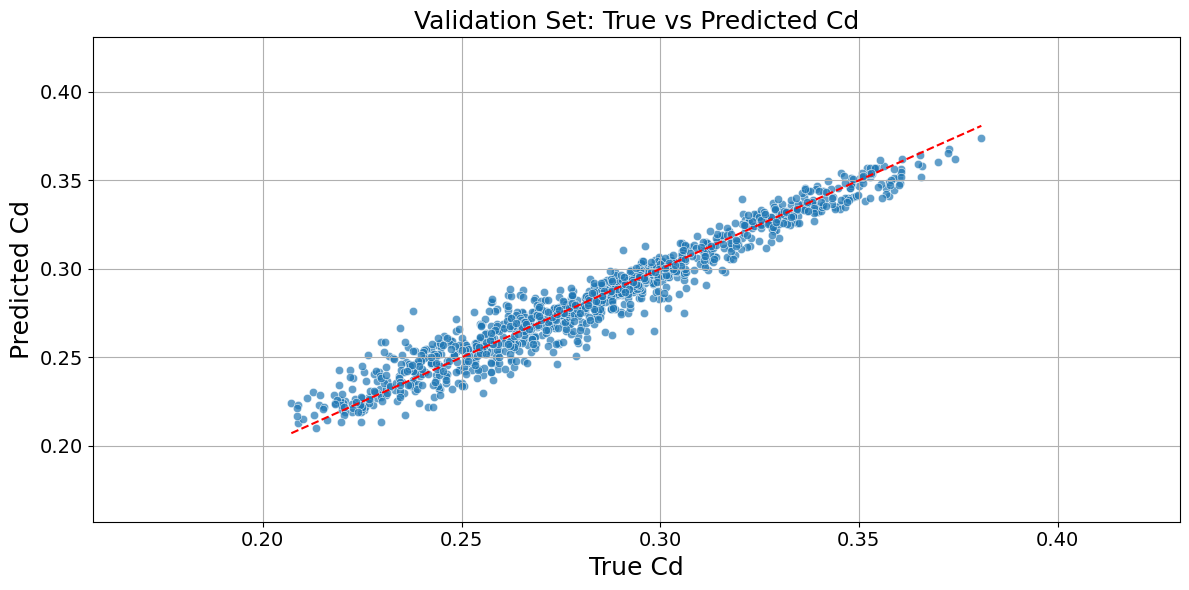

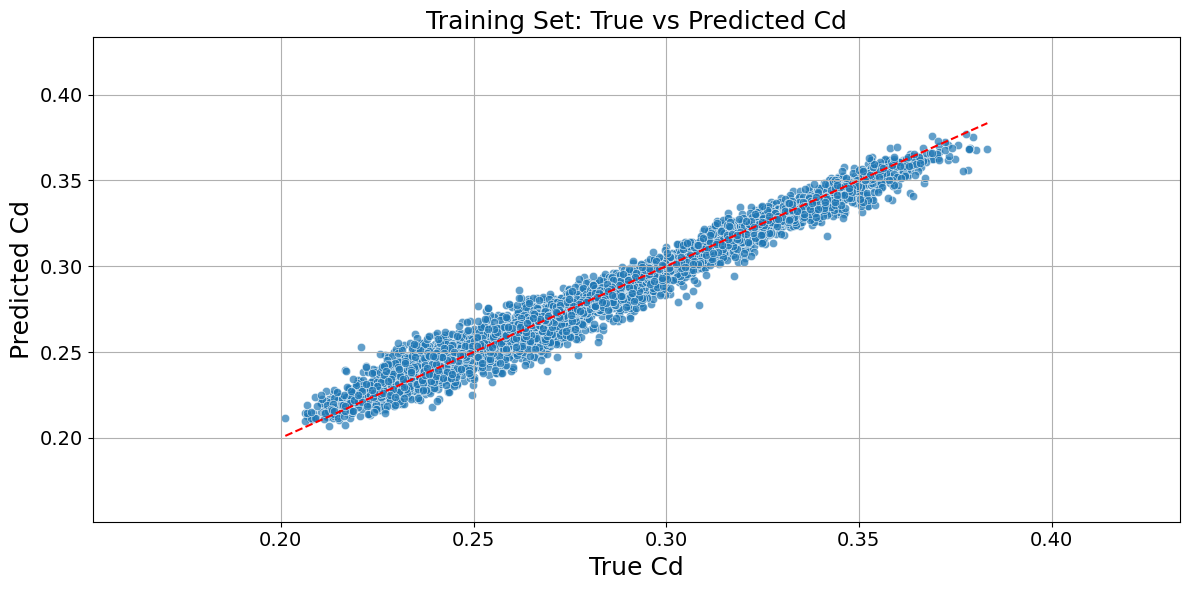

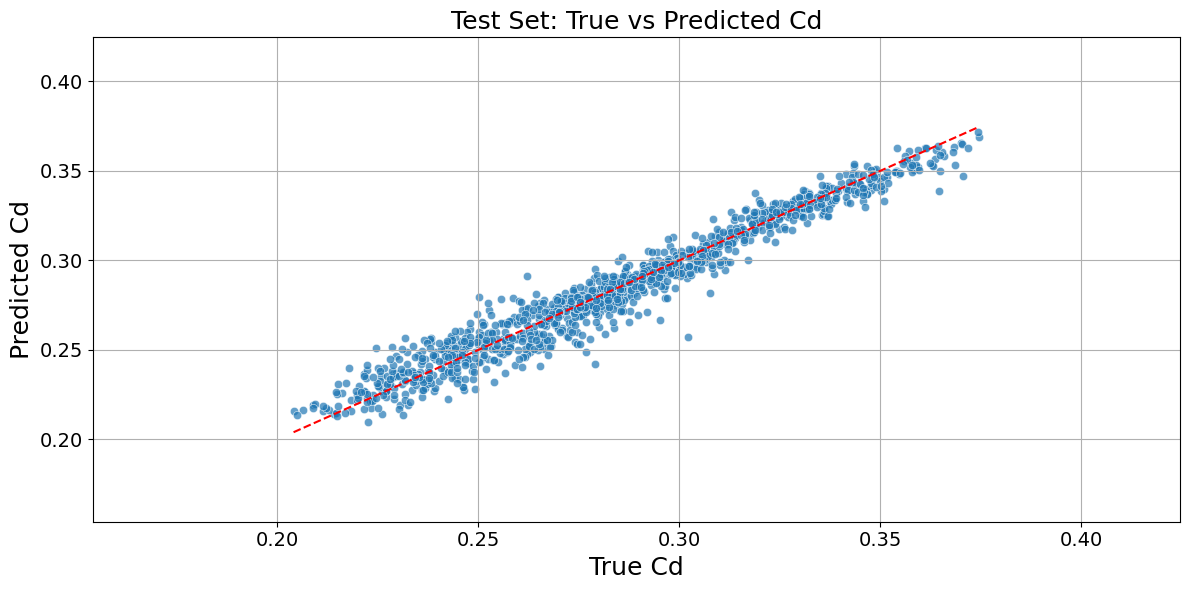

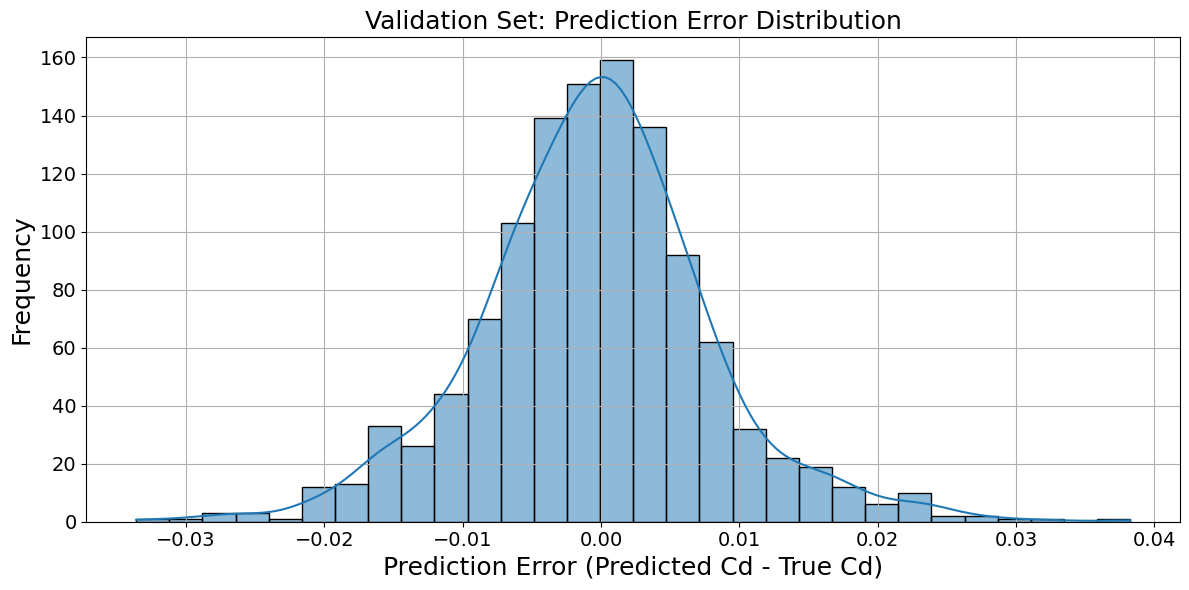

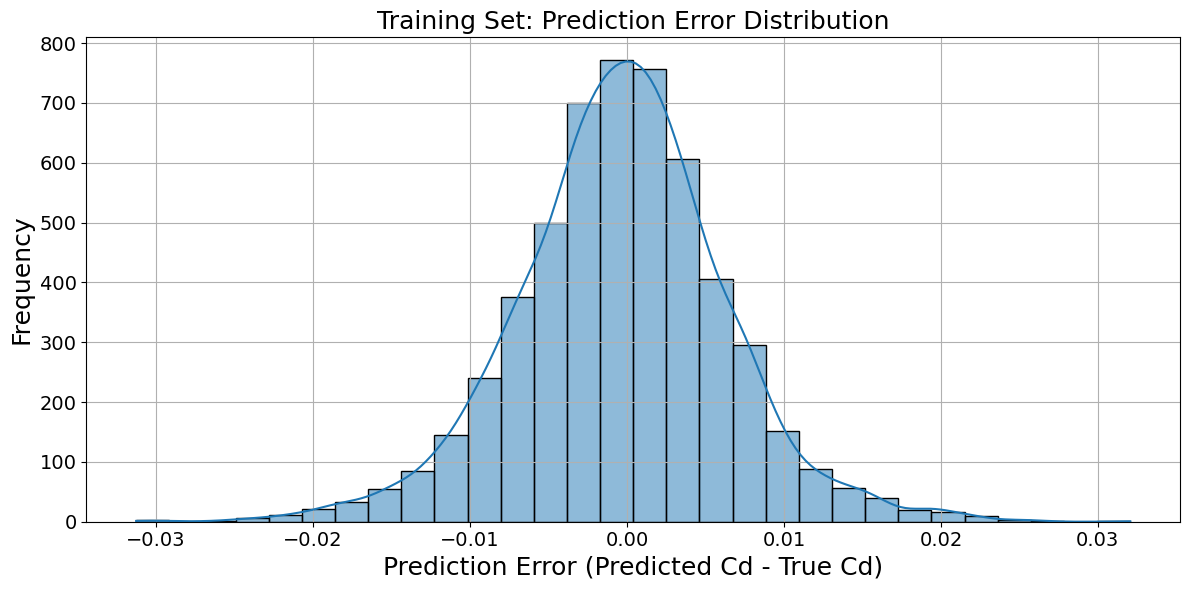

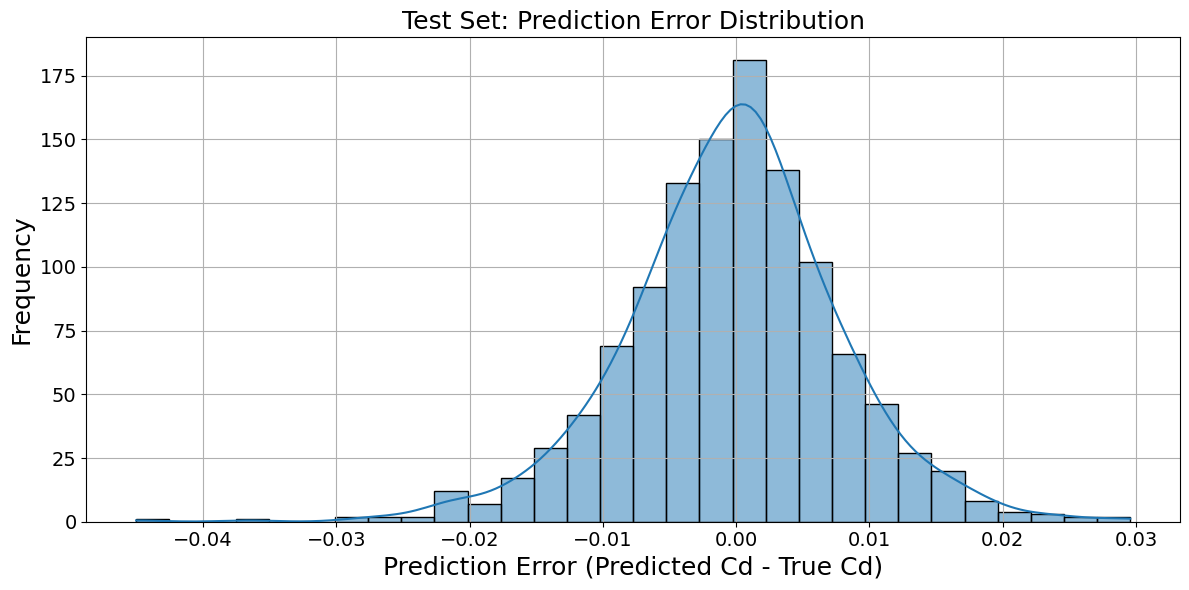

In [22]:
# Load the predictions
val_df = pd.read_csv("../outputs/eval/cd_predictions_val_design_ids.csv")
train_df = pd.read_csv("../outputs/eval/cd_predictions_train_design_ids.csv")
test_df = pd.read_csv("../outputs/eval/cd_predictions_test_design_ids.csv")

# Function to plot predictions
def plot_predictions(df, title, output_path):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="True Cd", y="Predicted Cd", data=df, alpha=0.7)
    plt.plot([df["True Cd"].min(), df["True Cd"].max()],
            [df["True Cd"].min(), df["True Cd"].max()],
            color='red', linestyle='--')
    plt.title(title, fontsize=18)
    plt.xlabel("True Cd", fontsize=18)
    plt.ylabel("Predicted Cd", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(xmin=min(df["True Cd"]) - 0.05, xmax=max(df["True Cd"]) + 0.05)
    plt.ylim(ymin=min(df["True Cd"]) - 0.05, ymax=max(df["True Cd"]) + 0.05)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()

# Plotting the distribution of errors
def plot_error_distribution(df, title, output_path):
    errors = df["Predicted Cd"] - df["True Cd"]
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title(title, fontsize=18)
    plt.xlabel("Prediction Error (Predicted Cd - True Cd)", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()

# Create output directory if it doesn't exist
os.makedirs("../outputs/eval", exist_ok=True)

# Plot for validation set
plot_predictions(
    val_df,
    title="Validation Set: True vs Predicted Cd",
    output_path="../outputs/eval/val_cd_predictions.png"
)

# Plot for training set
plot_predictions(
    train_df,
    title="Training Set: True vs Predicted Cd",
    output_path="../outputs/eval/train_cd_predictions.png"
)

# Plot for test set
plot_predictions(
    test_df,
    title="Test Set: True vs Predicted Cd",
    output_path="../outputs/eval/test_cd_predictions.png"
)

# Plot error distribution for validation set
plot_error_distribution(
    val_df,
    title="Validation Set: Prediction Error Distribution",
    output_path="../outputs/eval/val_cd_error_distribution.png"
)

# Plot error distribution for training set
plot_error_distribution(
    train_df,
    title="Training Set: Prediction Error Distribution",
    output_path="../outputs/eval/train_cd_error_distribution.png"
)

# Plot error distribution for test set
plot_error_distribution(
    test_df,
    title="Test Set: Prediction Error Distribution",
    output_path="../outputs/eval/test_cd_error_distribution.png"
)
